# Import Libraries

In [1]:
import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path
import warnings 
warnings.filterwarnings('ignore')

# Get Dataset From Kaggle

Input kaggle.json with private API 

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d soumikrakshit/anime-faces
! unzip /content/anime-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/data/552.png       

In [3]:
path = Path('/content/data/data')
len(os.listdir(path))

21551

# Getting the file names of all the images in the dataset

In [4]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

# Creating a TensorFlow dataset from the image filenames list

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(img_fn)

# Defining a preprocessing function for the images

In [6]:
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    img = (img - 127.5) / 127.5
    img = tf.image.resize(img, (64, 64))
    return img

# Preprocessing the images and caching the dataset

In [7]:
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [8]:
dataset = dataset.shuffle(21551).batch(128, drop_remainder=True)

In [9]:
dataset = dataset.prefetch(32)

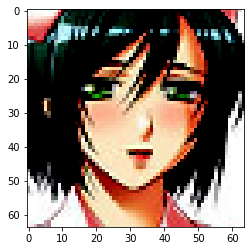

In [29]:
plt.imshow(next(dataset.as_numpy_iterator())[41])

In [11]:
next(dataset.as_numpy_iterator())[:8].shape

(8, 64, 64, 3)

# Displaying the first 8 images in the dataset

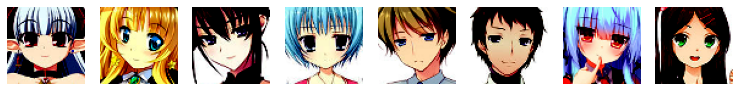

In [30]:
def show(images):
    fig, ax = plt.subplots(1, 8, figsize=(13, 13))
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(images[i]))
        a.axis('off')
    plt.show()
show(next(dataset.as_numpy_iterator())[:8])

# Defining a weight clipping constraint class

In [31]:
class WeightClipping(keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

# Define Conv Layers

In [32]:
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

# Define Critic Function

In [33]:
def critic(input_shape=(64, 64, 3), dim=64, n_downsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [34]:
d = critic()
d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_layer (ConvLayer)      (None, 32, 32, 64)        3200      
                                                                 
 conv_layer_1 (ConvLayer)    (None, 16, 16, 128)       131328    
                                                                 
 conv_layer_2 (ConvLayer)    (None, 8, 8, 256)         524800    
                                                                 
 conv_layer_3 (ConvLayer)    (None, 4, 4, 512)         2098176   
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 1)           8193      
                                                                 
 flatten (Flatten)           (None, 1)                 0     

# Define UpsampleBlock class and devconv layers

In [35]:
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

# Define Generator

In [36]:
def generator(input_shape=(1, 1, 128), output_channels=3, dim=64, n_upsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [37]:
g = generator()
g.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 upsample_block (UpsampleBlo  (None, 4, 4, 512)        1050112   
 ck)                                                             
                                                                 
 upsample_block_1 (UpsampleB  (None, 8, 8, 256)        2097920   
 lock)                                                           
                                                                 
 upsample_block_2 (UpsampleB  (None, 16, 16, 128)      524672    
 lock)                                                           
                                                                 
 upsample_block_3 (UpsampleB  (None, 32, 32, 64)       131264    
 lock)                                                     

# Define the Loss functions (WGAN so Wasserstein Loss)

In [38]:
#Wasserstein loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return real_loss + fake_loss

def g_loss(fake):
    return - tf.reduce_mean(fake)

# Define Gradient Penalty

In [39]:
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [53]:
EPOCHS = 10
BATCH_SIZE = 128
noise_dim = 128

In [54]:
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

# Defining the GAN (Generator and Discriminator)

In [55]:
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [56]:
seed = tf.random.normal((16, 1, 1, 128))

In [57]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, ax = plt.subplots(4, 4, figsize=(10,10))

    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.show()

# Define Training 

In [58]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=21551//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

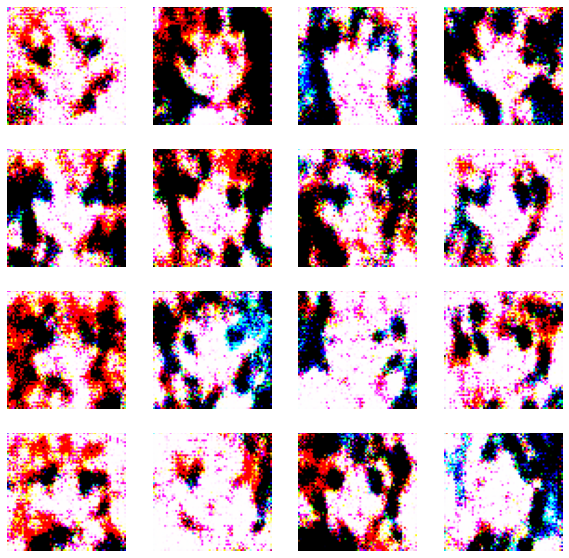

Time for epoch 1 is 82.83125448226929 sec


In [59]:
train(dataset, 1)
# 1 epochs

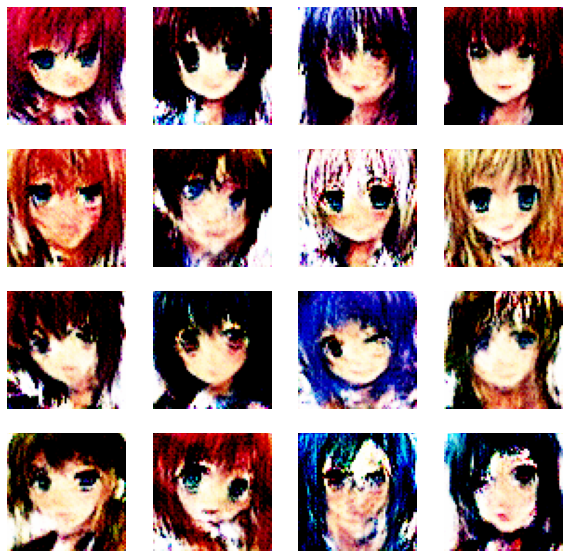

Time for epoch 30 is 46.204898834228516 sec


In [60]:
train(dataset, 30)

In [62]:
optG.lr = 1e-4
optD.lr = 1e-4

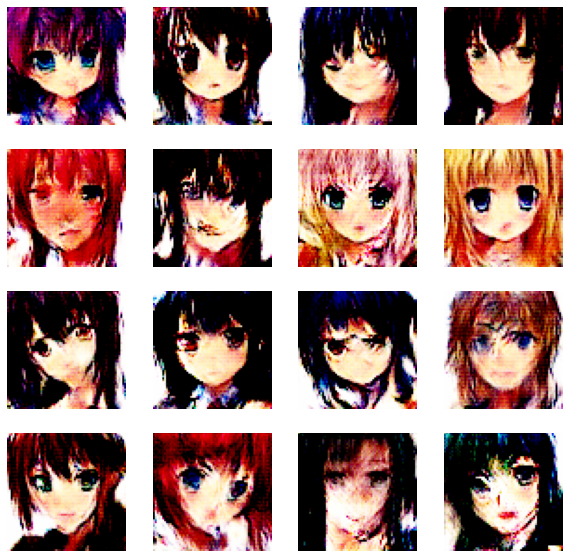

Time for epoch 30 is 46.76694440841675 sec


In [61]:
train(dataset, 30)

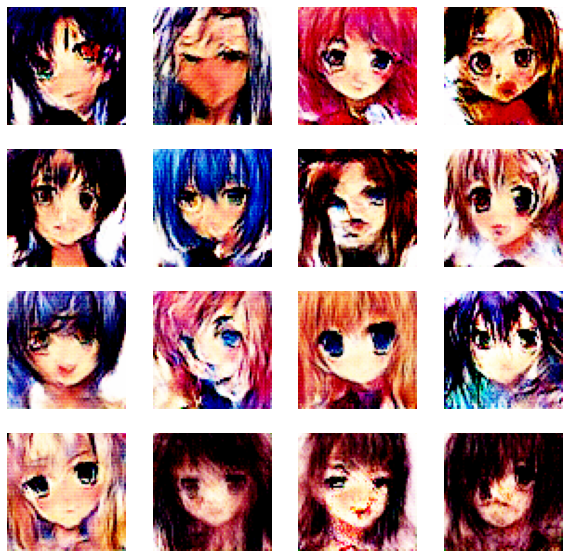

In [63]:
generate_images(g, 1, tf.random.normal([16, 1, 1, 128]))